<a href="https://colab.research.google.com/github/abeersethia/CCM_EEG/blob/main/LinearVNonLinear_LorenzAttractorReconstruction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

In [2]:
def generate_lorenz(n_steps=10000, dt=0.01, x0=[1.0, 1.0, 1.0]):
    def lorenz(state, t, sigma=10, rho=28, beta=8/3):
        x, y, z = state
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        return [dx, dy, dz]

    t = np.arange(0, n_steps * dt, dt)
    states = odeint(lorenz, x0, t)
    return states[:, 0]  # return x(t)

signal = generate_lorenz()

In [3]:
def build_hankel(signal, T):
    return np.array([signal[i:i+T] for i in range(len(signal) - T)])

T = 30  # Lag window size
X = build_hankel(signal, T)
Y = signal[T:]  # x_{t+1} target

# Normalize
X = (X - X.mean()) / X.std()
Y = (Y - Y.mean()) / Y.std()

# Convert to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)


In [4]:
class MLPAutoencoderTorch(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent

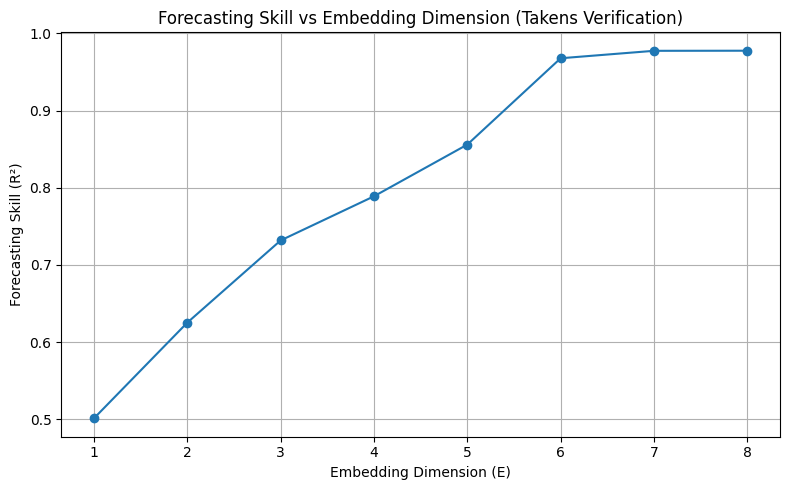

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparams
latent_dim = 8         # Fixed latent dimension
num_epochs = 50
lr = 1e-3
T = X_tensor.shape[1]  # Hankel window size

# Initialize model
model = MLPAutoencoderTorch(input_dim=T, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
X_tensor_device = X_tensor.to(device)

# Train the model
for epoch in range(num_epochs):
    model.train()
    X_hat, _ = model(X_tensor_device)
    loss = loss_fn(X_hat, X_tensor_device)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Get latent codes
model.eval()
with torch.no_grad():
    _, latent_codes = model(X_tensor_device)
    latent_codes = latent_codes.cpu().numpy()

# Prepare forecasting target
# Predict x_{t+T}, the next unseen point after each Hankel window
Y_target = signal[T:T + latent_codes.shape[0]]

# Forecasting Skill vs Embedding Dimension (E)
results = {}
for E in range(1, latent_dim + 1):  # E = 1 to L
    X_E = latent_codes[:, :E]
    reg = Ridge()
    reg.fit(X_E, Y_target)
    Y_pred = reg.predict(X_E)
    skill = r2_score(Y_target, Y_pred)
    results[E] = skill

# Plot
plt.figure(figsize=(8,5))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.title("Forecasting Skill vs Embedding Dimension (Takens Verification)")
plt.xlabel("Embedding Dimension (E)")
plt.ylabel("Forecasting Skill (R²)")
plt.grid(True)
plt.tight_layout()
plt.show()


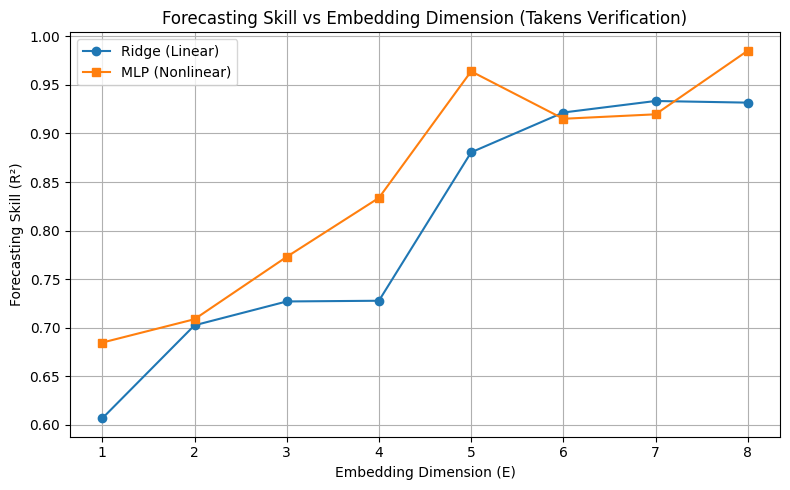

In [6]:
import torch.nn.functional as F

# Fixed latent dim
latent_dim = 8
num_epochs = 50

# Train autoencoder once
model = MLPAutoencoderTorch(input_dim=T, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
X_tensor_device = X_tensor.to(device)

for epoch in range(num_epochs):
    model.train()
    X_hat, _ = model(X_tensor_device)
    loss = loss_fn(X_hat, X_tensor_device)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Extract latent codes
model.eval()
with torch.no_grad():
    _, latent_codes = model(X_tensor_device)
    latent_codes = latent_codes.cpu()

# Forecasting target: x(t+T)
Y_target = signal[T:T + latent_codes.shape[0]]
Y_tensor = torch.tensor(Y_target, dtype=torch.float32).to(device)

# Store results
ridge_results = {}
mlp_results = {}

# Loop over embedding dimension E = 1 to latent_dim
for E in range(1, latent_dim + 1):
    X_E = latent_codes[:, :E].numpy()

    # --- Ridge Regression ---
    ridge = Ridge()
    ridge.fit(X_E, Y_target)
    Y_ridge_pred = ridge.predict(X_E)
    ridge_results[E] = r2_score(Y_target, Y_ridge_pred)

    # --- MLP Regressor ---
    class MLPRegressor(nn.Module):
        def __init__(self, input_dim, hidden_dim=64):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            )
        def forward(self, x):
            return self.model(x).squeeze(1)

    mlp = MLPRegressor(input_dim=E).to(device)
    mlp_optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

    X_E_tensor = torch.tensor(X_E, dtype=torch.float32).to(device)

    for epoch in range(500):
        mlp.train()
        pred = mlp(X_E_tensor)
        loss = F.mse_loss(pred, Y_tensor)
        mlp_optimizer.zero_grad()
        loss.backward()
        mlp_optimizer.step()

    mlp.eval()
    with torch.no_grad():
        Y_pred_mlp = mlp(X_E_tensor).cpu().numpy()
    mlp_results[E] = r2_score(Y_target, Y_pred_mlp)

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(list(ridge_results.keys()), list(ridge_results.values()), marker='o', label='Ridge (Linear)')
plt.plot(list(mlp_results.keys()), list(mlp_results.values()), marker='s', label='MLP (Nonlinear)')
plt.title("Forecasting Skill vs Embedding Dimension (Takens Verification)")
plt.xlabel("Embedding Dimension (E)")
plt.ylabel("Forecasting Skill (R²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
